<a href="https://colab.research.google.com/github/oxanaRC/CE902/blob/main/Random_forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

15.08.21
Upload three csv files:
1. dataset for training and testing 
2. dataset for validation
3. dataset for records identification ('location key', 'postal code' and 'district) - this to be joined with data after predictions were done so the quality of predictions could be analysed by location.



In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving train_and_test_data.csv to train_and_test_data.csv
Saving locations_categorical_features.csv to locations_categorical_features.csv
Saving validation_data.csv to validation_data.csv
User uploaded file "train_and_test_data.csv" with length 264291598 bytes
User uploaded file "locations_categorical_features.csv" with length 27878177 bytes
User uploaded file "validation_data.csv" with length 8934313 bytes


In [2]:
import pandas as pd
from pathlib import Path

In [3]:
df_location_categories = pd.read_csv("locations_categorical_features.csv") 
df_location_categories

,location_key,postcode,district
0,100000460_235813700_173697830,IP28 6QS,ST EDMUNDSBURY
1,100000900_306645770_193413260,PO2 9AE,PORTSMOUTH
2,100001709_306232250_192988720,PO2 8NT,PORTSMOUTH
3,100002450_241021470_178393000,IP33 3UF,ST EDMUNDSBURY
4,100002500_240933210_178314290,IP33 3UE,ST EDMUNDSBURY
...,...,...,...
563834,99996430_240804040_178195840,IP33 3UN,WEST SUFFOLK
563835,99996800_303056370_189735890,PO16 9PA,FAREHAM
563836,99998470_302856560_189531620,PO16 9UH,FAREHAM
563837,99998690_306575700_193341460,PO2 9BS,PORTSMOUTH


In [4]:
df_train_test_data = pd.read_csv("train_and_test_data.csv") 
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,price_paid
0,1,L,T,23.0,110.178111,0.671216,96.0,0.5,0.9,60000.000000,56187.500000,110333.333333,22666.666667,87666.666667,7,26510768000,718540000,11622296000,53.489825,-2.358860,100000.0,66.666667,77.975528,100000.0
1,1,L,S,24.0,78.275669,0.320619,15.0,10.8,9.4,79166.666667,79000.000000,136000.000000,45000.000000,91000.000000,23,26539970000,542647000,11902983000,53.528583,-2.270335,79500.0,0.421053,0.632911,79500.0
2,1,L,F,12.0,85.979811,0.584296,20.0,11.5,9.8,73416.666667,64341.666667,154000.000000,42750.000000,111250.000000,4,16016690000,25505656000,21724217000,52.637255,1.298314,128000.0,74.347333,98.937961,128000.0
3,1,L,F,3.0,89.636307,0.452391,13.0,9.7,8.3,101666.666667,101666.666667,215000.000000,62750.000000,152250.000000,14,6296533000,26014878000,18039516000,51.868112,0.544362,170000.0,67.213115,67.213115,170000.0
4,1,F,S,6.0,55.701643,1.752959,14.0,11.9,11.0,136250.000000,168104.166667,252500.000000,60000.000000,192500.000000,18,4111570000,27468619000,16632627000,51.236727,-0.560636,655000.0,380.733945,289.639361,655000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1144234,5,F,D,1.0,0.000000,0.000000,0.0,0.0,0.0,87250.000000,92500.000000,152500.000000,46750.000000,105750.000000,16,18126308000,28825475000,18214946000,50.896436,-2.576097,114000.0,30.659026,23.243243,570000.0
1144235,5,F,D,24.0,97.697793,1.639435,97.0,1.9,2.8,105000.000000,107500.000000,440000.000000,16000.000000,424000.000000,4,25424316000,711278000,10659618000,53.417210,-2.246727,178000.0,69.523810,65.581395,890000.0
1144236,5,F,S,6.0,193.121503,1.094252,26.0,8.7,8.3,89750.000000,92500.000000,163333.333333,45250.000000,118083.333333,9,8815989000,34831047000,24742056000,50.868112,0.567342,65600.0,-26.908078,-29.081081,328000.0
1144237,5,F,D,6.0,46.650826,2.156095,27.0,9.5,8.1,57750.000000,57750.000000,162500.000000,24666.666667,137833.333333,2,29718009000,3717254000,14712579000,53.731672,-2.624259,42800.0,-25.887446,-25.887446,214000.0


In [5]:
df_validation_data = pd.read_csv("validation_data.csv") 
df_validation_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,this_price_per_bedroom,compare_ppd_re_hist_median_3mnths,compare_ppd_re_hist_median_4mnths,price_paid
0,1,L,F,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,459500.000000,175000.000000,284500.000000,26,770794900,26771245000,16701868000,51.446749,-0.137157,314000.0,10.175439,-3.754789,314000.0
1,1,F,T,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,187500.000000,80000.000000,107500.000000,26,2095469000,26684681000,17218624000,51.564821,0.123801,225000.0,98.529412,88.811189,225000.0
2,1,L,F,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,165833.333333,45000.000000,120833.333333,26,10333301000,30370523000,19027695000,50.830953,-1.173732,120000.0,29.380054,50.000000,120000.0
3,1,L,F,60.0,104.272807,0.530036,60.0,9.2,8.7,219083.333333,240000.000000,360000.000000,131666.666667,228333.333333,26,502176000,26527685000,16536000000,51.478533,-0.121591,500000.0,128.223659,108.333333,500000.0
4,1,L,F,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,185000.000000,27400.000000,157600.000000,26,32407942000,6604266000,17029935000,53.856740,-3.027827,52000.0,23.809524,21.188580,52000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38522,5,F,D,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,167500.000000,20000.000000,147500.000000,26,22886393000,4770220000,7212565000,53.060015,-2.388207,78750.0,50.000000,42.319277,393750.0
38523,5,F,S,1.0,62.208157,4.362943,38.0,7.5,7.3,92333.333333,97000.000000,245000.000000,40625.000000,204375.000000,26,8821511000,25299709000,18394460000,52.085717,0.720703,186000.0,101.444043,91.752577,930000.0
38524,5,F,D,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,250000.000000,84000.000000,166000.000000,26,6938065000,27433863000,19483321000,51.800099,0.725616,112000.0,6.140178,5.000000,560000.0
38525,5,F,T,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,268000.000000,65000.000000,203000.000000,26,7548684000,32765304000,21992537000,50.834805,-0.137428,108400.0,-33.885642,-31.734453,542000.0


In [6]:
#remove outliers
#df_train_test_data=df_train_test_data[(df_train_test_data['num_of_beds'] <=5) & (df_train_test_data['price_paid'] > 10000) & (df_train_test_data['price_paid'] <1000000) ]
#df_validation_data=df_validation_data[(df_validation_data['num_of_beds'] <=5) & (df_validation_data['price_paid'] > 10000) & (df_validation_data['price_paid'] <1000000) ]
#remove outliers
df_train_test_data=df_train_test_data[(df_train_test_data['closest_sch_distance'] !=0) ]
df_validation_data=df_validation_data[(df_validation_data['closest_sch_distance'] !=0) ]
#-------------------------------------------------------------------------------------------------------
df_train_test_data=df_train_test_data[(df_train_test_data['compare_ppd_re_hist_median_3mnths'] <=100) ]
df_train_test_data=df_train_test_data[(df_train_test_data['compare_ppd_re_hist_median_4mnths'] <=100) ]
df_validation_data=df_validation_data[(df_validation_data['compare_ppd_re_hist_median_3mnths']<=100) ]
df_validation_data=df_validation_data[(df_validation_data['compare_ppd_re_hist_median_4mnths'] <=100) ]

In [7]:
#remove columns: 'this_price_per_bedroom',	'compare_ppd_re_hist_median_3mnths',	'compare_ppd_re_hist_median_4mnths'
df_train_test_data=df_train_test_data.drop(['this_price_per_bedroom', 'compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths'], axis = 1)
df_validation_data=df_validation_data.drop(['this_price_per_bedroom', 'compare_ppd_re_hist_median_3mnths','compare_ppd_re_hist_median_4mnths'], axis = 1)


In [8]:
estateTypes=df_train_test_data['estate_type'].unique()
estateTypes

array(['L', 'F'], dtype=object)

In [9]:
df_train_test_data['estate_type'] =df_train_test_data['estate_type'].map({'F':'2',
                             'L':'1'})
df_validation_data['estate_type'] =df_validation_data['estate_type'].map({'F':'2',
                             'L':'1'})


In [10]:
propertyTypes=df_train_test_data['property_type'].unique()
propertyTypes

array(['T', 'S', 'F', 'D'], dtype=object)

In [11]:
df_train_test_data['property_type'] =df_train_test_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})
df_validation_data['property_type'] =df_validation_data['property_type'].map({'O':'5','D':'4','S':'3','T':'2','F':'1'})

              

In [12]:
#shuffle the train_test dataset
df_train_test_data = df_train_test_data.sample(frac = 1)
df_train_test_data

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,price_paid
742148,3,2,2,2.0,46.746569,0.898763,18.0,9.7,9.3,40250.000000,40000.000000,75000.000000,30000.000000,45000.000000,17,39931084000,16615264000,27547266000,54.958168,-1.864542,93000.0
703807,3,2,3,27.0,96.899301,0.826481,55.0,8.8,7.3,71666.666667,78333.333333,140000.000000,50000.000000,90000.000000,20,16420012000,11520705000,797755000,52.454852,-2.015010,215000.0
454761,3,2,3,10.0,56.221266,0.713031,19.0,12.8,10.0,61250.000000,52666.666667,154000.000000,24666.666667,129333.333333,6,27285598900,2249063000,11964359000,53.474539,-2.590932,123000.0
1088003,4,2,4,4.0,70.937209,0.179855,33.0,9.0,7.6,98333.333333,108562.500000,181666.666667,76400.000000,105266.666667,20,8523480000,34551883000,24335015000,50.853471,0.454444,417500.0
1074982,4,2,4,1.0,37.000598,2.636309,11.0,10.6,10.4,132000.000000,116666.666667,217500.000000,85833.333333,131666.666667,12,6017167900,31888066000,21467563000,50.996624,0.088814,605000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83785,2,2,3,8.0,69.037901,1.498440,15.0,9.9,9.2,120000.000000,95750.000000,250000.000000,64000.000000,186000.000000,5,8193858000,34106598000,23663298000,50.824147,0.248006,283000.0
988201,4,2,3,31.0,36.178480,1.506472,37.0,7.9,7.0,141250.000000,151250.000000,332500.000000,73333.333333,259166.666667,25,2335124000,28055455000,18295395000,51.417891,0.132502,395000.0
459240,3,2,2,64.0,96.621589,0.377379,52.0,8.4,6.8,212500.000000,210833.333333,402000.000000,158333.333333,243666.666667,25,937000000,25655359000,15913878000,51.583631,-0.092808,680000.0
402973,3,1,3,16.0,75.158165,1.475868,63.0,7.4,6.9,48333.333333,46000.000000,90000.000000,26666.666667,63333.333333,24,22285076000,5793892000,10485514000,53.372509,-1.395974,160000.0


In [13]:
dataset = df_train_test_data.values
dataset

array([[3, '2', '2', ..., 54.95816800000001, -1.864542, 93000.0],
       [3, '2', '3', ..., 52.454852, -2.0150099999999997, 215000.0],
       [3, '2', '3', ..., 53.474539, -2.590932, 123000.0],
       ...,
       [3, '2', '2', ..., 51.583631, -0.092808, 680000.0],
       [3, '1', '3', ..., 53.372508999999994, -1.395974, 160000.0],
       [3, '2', '4', ..., 50.516802, -4.828766000000001, 345000.0]],
      dtype=object)

In [14]:
X1 = dataset[:,0:20]
Y1 = dataset[:,20]
#all features

In [15]:
validation_dataset=df_validation_data.values
validation_dataset

array([[1, '1', '1', ..., 51.446749, -0.137157, 314000.0],
       [1, '2', '2', ..., 51.564821, 0.123801, 225000.0],
       [1, '1', '1', ..., 50.830953, -1.173732, 120000.0],
       ...,
       [5, '2', '4', ..., 51.800098999999996, 0.725616, 560000.0],
       [5, '2', '2', ..., 50.834804999999996, -0.137428, 542000.0],
       [5, '2', '4', ..., 50.778189000000005, 0.102345, 412000.0]],
      dtype=object)

In [16]:
X_Validation=validation_dataset[:,0:20]
Y_Validation =validation_dataset[:,20]

In [17]:
from sklearn import preprocessing

In [18]:
min_max_scaler = preprocessing.MinMaxScaler()

In [19]:
X1_scale = min_max_scaler.fit_transform(X1)
X1_scale

array([[0.5       , 1.        , 0.33333333, ..., 0.73265316, 0.85717716,
        0.5145809 ],
       [0.5       , 1.        , 0.66666667, ..., 0.01946537, 0.42567697,
        0.49441074],
       [0.5       , 1.        , 0.66666667, ..., 0.31718616, 0.60144189,
        0.41720871],
       ...,
       [0.5       , 1.        , 0.33333333, ..., 0.42248711, 0.27550335,
        0.75208088],
       [0.5       , 0.        , 0.66666667, ..., 0.27775762, 0.58385483,
        0.57739218],
       [0.5       , 1.        , 1.        , ..., 0.79190386, 0.09161249,
        0.11722826]])

In [20]:

print(min(Y1))
print(max(Y1))

14500.0
999999.0


In [21]:
X_Validation_scale = min_max_scaler.transform(X_Validation)
X_Validation_scale

array([[0.        , 0.        , 0.        , ..., 0.44349627, 0.2519088 ,
        0.74613592],
       [0.        , 1.        , 0.33333333, ..., 0.45727387, 0.27226104,
        0.7811172 ],
       [0.        , 0.        , 0.        , ..., 0.5055068 , 0.14576315,
        0.6071836 ],
       ...,
       [1.        , 1.        , 1.        , ..., 0.51765457, 0.31281625,
        0.86179018],
       [1.        , 1.        , 0.33333333, ..., 0.58455457, 0.14642713,
        0.7460996 ],
       [1.        , 1.        , 1.        , ..., 0.62369645, 0.13666815,
        0.77824104]])

In [22]:
print(min(Y_Validation))
print(max(Y_Validation))

18000.0
999000.0


In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1_scale, Y1, test_size=0.1)

In [25]:
print(X1_train.shape, X1_test.shape, Y1_train.shape, Y1_test.shape)

(922946, 20) (102550, 20) (922946,) (102550,)


In [26]:
from sklearn.ensemble import RandomForestRegressor

In [72]:
regr1 = RandomForestRegressor(max_depth=15, random_state=0)
regr1.fit(X1_train, Y1_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [73]:
prediction1=regr1.predict(X1_test)
#print(prediction1)

In [74]:
prediction_df1 = pd.DataFrame(min_max_scaler.inverse_transform(X1_test)) 
prediction_df1.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','max_ppb_3mnths_ago',	'min_ppb_3mnths_ago',	'spread_ppb_3mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long']
prediction_df1['Y1'] = Y1_test
prediction_df1['predictions1'] = prediction1
prediction_df1['error1']=prediction_df1['Y1']-prediction_df1['predictions1']
prediction_df1['sq_error1']=pow((prediction_df1['Y1']-prediction_df1['predictions1']),2)
prediction_df1['root_sq_error1']=pow(pow((prediction_df1['Y1']-prediction_df1['predictions1']),2),0.5)
prediction_df1['location_key']=(round((prediction_df1['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_df1['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_df1['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_df1

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key
0,3.0,2.0,3.0,10.0,80.055378,1.891262,33.0,9.1,8.7,99975.000000,92500.000000,230000.0,57600.000000,172400.000000,25.0,2.757739e+10,6.432172e+09,1.552411e+10,53.856615,-1.508525,267000,258552.125547,8447.87,7.13666e+07,8447.87,275773870_64321720_155241090
1,3.0,2.0,2.0,14.0,80.181149,0.694295,26.0,10.6,9.4,57000.000000,56000.000000,181250.0,26666.666667,154583.333333,21.0,1.782666e+10,9.141251e+09,7.801023e+09,53.003823,-1.132715,140000,134799.373221,5200.63,2.70465e+07,5200.63,178266620_91412510_78010230
2,4.0,2.0,2.0,32.0,56.458712,0.487204,20.0,10.5,8.4,129000.000000,145000.000000,210000.0,95000.000000,115000.000000,25.0,2.034382e+09,2.768578e+10,1.794569e+10,51.446851,0.105974,475000,447487.038500,27513,7.56963e+08,27513,20343820_276857760_179456880
3,5.0,2.0,4.0,2.0,62.577710,0.115857,9.0,10.9,10.3,74791.666667,73229.166667,115000.0,68333.333333,46666.666667,19.0,2.998220e+10,5.528616e+09,1.421812e+10,53.546489,-3.080149,545000,492752.705780,52247.3,2.72978e+09,52247.3,299822000_55286160_142181150
4,2.0,2.0,2.0,17.0,100.736068,1.474631,64.0,6.0,5.6,50833.333333,50833.333333,92500.0,27000.000000,65500.000000,1.0,1.773921e+10,8.355322e+09,5.536056e+09,52.898762,-1.458709,110000,96377.686795,13622.3,1.85567e+08,13622.3,177392080_83553220_55360560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102545,2.0,2.0,2.0,18.0,105.074894,0.854486,50.0,2.7,3.3,44812.500000,44812.500000,110000.0,18333.333333,91666.666667,3.0,2.773655e+10,1.759092e+09,1.282157e+10,53.586521,-2.449741,63500,77034.574404,-13534.6,1.83185e+08,13534.6,277365500_17590920_128215660
102546,3.0,1.0,3.0,14.0,65.611330,1.256553,20.0,9.8,9.2,68375.000000,61625.000000,142500.0,39333.333333,103166.666667,15.0,2.733403e+10,1.322430e+09,1.265734e+10,53.589880,-2.332213,217000,191550.166513,25449.8,6.47694e+08,25449.8,273340260_13224300_126573370
102547,2.0,2.0,4.0,6.0,71.489686,0.870844,38.0,8.6,8.4,60000.000000,61500.000000,120000.0,35666.666667,84333.333333,15.0,1.932941e+10,7.845927e+09,3.601786e+09,52.780872,-2.106656,208000,183012.106581,24987.9,6.24395e+08,24987.9,193294080_78459270_36017860
102548,2.0,2.0,2.0,9.0,48.160799,0.195512,13.0,10.8,9.6,109166.666667,105803.000000,165000.0,74166.666667,90833.333333,13.0,2.779476e+10,9.260356e+09,1.721851e+10,53.950126,-1.088339,280000,232207.767169,47792.2,2.2841e+09,47792.2,277947559_92603560_172185110


In [75]:
data_for_prediction_analysis = pd.merge(prediction_df1, df_location_categories, how="left", on="location_key")
data_for_prediction_analysis['postcode_area']=data_for_prediction_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,3.0,2.0,3.0,10.0,80.055378,1.891262,33.0,9.1,8.7,99975.000000,92500.000000,230000.0,57600.000000,172400.000000,25.0,2.757739e+10,6.432172e+09,1.552411e+10,53.856615,-1.508525,267000,258552.125547,8447.87,7.13666e+07,8447.87,275773870_64321720_155241090,LS17 8SX,LEEDS,LS17
1,3.0,2.0,2.0,14.0,80.181149,0.694295,26.0,10.6,9.4,57000.000000,56000.000000,181250.0,26666.666667,154583.333333,21.0,1.782666e+10,9.141251e+09,7.801023e+09,53.003823,-1.132715,140000,134799.373221,5200.63,2.70465e+07,5200.63,178266620_91412510_78010230,NG5 7AP,GEDLING,NG5
2,4.0,2.0,2.0,32.0,56.458712,0.487204,20.0,10.5,8.4,129000.000000,145000.000000,210000.0,95000.000000,115000.000000,25.0,2.034382e+09,2.768578e+10,1.794569e+10,51.446851,0.105974,475000,447487.038500,27513,7.56963e+08,27513,20343820_276857760_179456880,DA15 9HA,BEXLEY,DA15
3,5.0,2.0,4.0,2.0,62.577710,0.115857,9.0,10.9,10.3,74791.666667,73229.166667,115000.0,68333.333333,46666.666667,19.0,2.998220e+10,5.528616e+09,1.421812e+10,53.546489,-3.080149,545000,492752.705780,52247.3,2.72978e+09,52247.3,299822000_55286160_142181150,L37 2YT,SEFTON,L37
4,2.0,2.0,2.0,17.0,100.736068,1.474631,64.0,6.0,5.6,50833.333333,50833.333333,92500.0,27000.000000,65500.000000,1.0,1.773921e+10,8.355322e+09,5.536056e+09,52.898762,-1.458709,110000,96377.686795,13622.3,1.85567e+08,13622.3,177392080_83553220_55360560,DE24 8XW,CITY OF DERBY,DE24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102545,2.0,2.0,2.0,18.0,105.074894,0.854486,50.0,2.7,3.3,44812.500000,44812.500000,110000.0,18333.333333,91666.666667,3.0,2.773655e+10,1.759092e+09,1.282157e+10,53.586521,-2.449741,63500,77034.574404,-13534.6,1.83185e+08,13534.6,277365500_17590920_128215660,BL1 3BS,BOLTON,BL1
102546,3.0,1.0,3.0,14.0,65.611330,1.256553,20.0,9.8,9.2,68375.000000,61625.000000,142500.0,39333.333333,103166.666667,15.0,2.733403e+10,1.322430e+09,1.265734e+10,53.589880,-2.332213,217000,191550.166513,25449.8,6.47694e+08,25449.8,273340260_13224300_126573370,BL8 2HP,BURY,BL8
102547,2.0,2.0,4.0,6.0,71.489686,0.870844,38.0,8.6,8.4,60000.000000,61500.000000,120000.0,35666.666667,84333.333333,15.0,1.932941e+10,7.845927e+09,3.601786e+09,52.780872,-2.106656,208000,183012.106581,24987.9,6.24395e+08,24987.9,193294080_78459270_36017860,ST17 4HQ,STAFFORD,ST17
102548,2.0,2.0,2.0,9.0,48.160799,0.195512,13.0,10.8,9.6,109166.666667,105803.000000,165000.0,74166.666667,90833.333333,13.0,2.779476e+10,9.260356e+09,1.721851e+10,53.950126,-1.088339,280000,232207.767169,47792.2,2.2841e+09,47792.2,277947559_92603560_172185110,YO23 1NJ,YORK,YO23


In [76]:
#check NA in data_for_prediction_analysis
data_for_prediction_analysis_na=data_for_prediction_analysis[(data_for_prediction_analysis['postcode'].isnull())]
data_for_prediction_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y1,predictions1,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [ ]:
from google.colab import files
with open('test data predictions.csv', 'w') as f:
  #f.write('some content')
  data_for_prediction_analysis.to_csv('test data predictions.csv', index=False)
files.download('test data predictions.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [77]:
root_mse1=pow(prediction_df1['sq_error1'].sum()/prediction_df1['sq_error1'].count(),0.5)
root_mse1

61317.84627785905

In [78]:
#considering good prediction where error 10% or less
prediction_df1['error_perc']=100*prediction_df1['root_sq_error1']/prediction_df1['Y1']
good_prediction_10pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1=100*good_prediction_10pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1 =prediction_df1[(prediction_df1['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1 =prediction_df1[(prediction_df1['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1=100*good_prediction_15pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1) + ' %')
#prediction_20pc_df1
within_20pc_error1=100*prediction_20pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1) + ' %')
#prediction_50pc_df1
within_50pc_error1=100*prediction_over50pc_df1.shape[0]/prediction_df1.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1) + ' %')

Predictions where error is 10% or less :40.432959531935644 %
Predictions where error is 15% or less :56.21257922964408 %
Predictions where error is 20% or less :68.29254022428084 %
Predictions where error is 50% or more :4.951730862993662 %


In [79]:
prediction_validation=regr1.predict(X_Validation_scale)

In [80]:
prediction_validation_df = pd.DataFrame(min_max_scaler.inverse_transform(X_Validation_scale))
prediction_validation_df.columns =['num_of_beds', 'estate_type', 'property_type','num_of_sec_sch','score_disadv','closest_sch_distance', 'closest_disadv_prct',	'closest_aver_attain_eng',	'closest_aver_attain_math','median_ppb_3mnths_ago','median_ppb_4mnths_ago','max_ppb_3mnths_ago',	'min_ppb_3mnths_ago',	'spread_ppb_3mnths_ago','hist_mnth',	'distances_Lond',	'distances_Manch',	'distances_Birming','lat',	'long'] 
prediction_validation_df['Y_val_data'] = Y_Validation
prediction_validation_df['predictions_validation'] = prediction_validation
prediction_validation_df['error1']=prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']
prediction_validation_df['sq_error1']=pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2)
prediction_validation_df['root_sq_error1']=pow(pow((prediction_validation_df['predictions_validation']-prediction_validation_df['Y_val_data']),2),0.5)
prediction_validation_df['location_key']=(round((prediction_validation_df['distances_Lond']*0.01),0).astype(int)).astype(str) + '_' + (round((prediction_validation_df['distances_Manch']*0.01),0).astype(int)).astype(str)+ '_' + (round((prediction_validation_df['distances_Birming']*0.01),0).astype(int)).astype(str)
prediction_validation_df

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,459500.000000,175000.000000,284500.000000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,413494.695375,99494.7,9.89919e+09,99494.7,7707949_267712450_167018680
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,187500.000000,80000.000000,107500.000000,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,205884.989485,-19115,3.65384e+08,19115,20954690_266846810_172186240
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,165833.333333,45000.000000,120833.333333,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,118106.155210,-1893.84,3.58665e+06,1893.84,103333010_303705230_190276950
3,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,185000.000000,27400.000000,157600.000000,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,48895.924762,-3104.08,9.63528e+06,3104.08,324079420_66042660_170299350
4,1.0,2.0,2.0,2.0,83.923313,1.155743,22.0,9.1,8.6,76000.000000,101458.333333,125333.333333,33333.333333,92000.000000,26.0,2.742032e+10,2.925586e+10,2.137504e+10,51.092224,-4.054447,133000,126843.580499,-6156.42,3.79015e+07,6156.42,274203190_292558650_213750350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34755,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.000000,96666.666667,163333.333333,56000.000000,107333.333333,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,378320.024620,61320,3.76015e+09,61320,148740500_304966640_192878440
34756,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,167500.000000,20000.000000,147500.000000,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,373940.035662,-19810,3.92435e+08,19810,228863930_47702200_72125650
34757,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,250000.000000,84000.000000,166000.000000,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,595957.768243,35957.8,1.29296e+09,35957.8,69380650_274338630_194833210
34758,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,268000.000000,65000.000000,203000.000000,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,680290.940891,138291,1.91244e+10,138291,75486840_327653040_219925370


In [81]:
data_for_prediction_validation_analysis = pd.merge(prediction_validation_df, df_location_categories, how="left", on="location_key")
data_for_prediction_validation_analysis['postcode_area']=data_for_prediction_validation_analysis['postcode'].str.split(' ').str[0]
data_for_prediction_validation_analysis

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area
0,1.0,1.0,1.0,54.0,92.304597,0.543902,36.0,11.4,9.6,285000.000000,326250.000000,459500.000000,175000.000000,284500.000000,26.0,7.707949e+08,2.677124e+10,1.670187e+10,51.446749,-0.137157,314000,413494.695375,99494.7,9.89919e+09,99494.7,7707949_267712450_167018680,SW12 0JP,LAMBETH,SW12
1,1.0,2.0,2.0,35.0,78.178630,0.086689,36.0,8.9,8.4,113333.333333,119166.666667,187500.000000,80000.000000,107500.000000,26.0,2.095469e+09,2.668468e+10,1.721862e+10,51.564821,0.123801,225000,205884.989485,-19115,3.65384e+08,19115,20954690_266846810_172186240,RM8 1UG,REDBRIDGE,RM8
2,1.0,1.0,1.0,11.0,67.921534,0.836103,32.0,7.6,7.0,92750.000000,80000.000000,165833.333333,45000.000000,120833.333333,26.0,1.033330e+10,3.037052e+10,1.902770e+10,50.830953,-1.173732,120000,118106.155210,-1893.84,3.58665e+06,1893.84,103333010_303705230_190276950,PO13 0XF,GOSPORT,PO13
3,1.0,1.0,1.0,9.0,125.415966,0.658497,39.0,9.0,7.6,42000.000000,42908.333333,185000.000000,27400.000000,157600.000000,26.0,3.240794e+10,6.604266e+09,1.702994e+10,53.856740,-3.027827,52000,48895.924762,-3104.08,9.63528e+06,3104.08,324079420_66042660_170299350,FY2 0HD,BLACKPOOL,FY2
4,1.0,2.0,2.0,2.0,83.923313,1.155743,22.0,9.1,8.6,76000.000000,101458.333333,125333.333333,33333.333333,92000.000000,26.0,2.742032e+10,2.925586e+10,2.137504e+10,51.092224,-4.054447,133000,126843.580499,-6156.42,3.79015e+07,6156.42,274203190_292558650_213750350,EX31 1NY,NORTH DEVON,EX31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34755,5.0,2.0,3.0,14.0,62.851908,1.463653,39.0,7.0,5.7,95000.000000,96666.666667,163333.333333,56000.000000,107333.333333,26.0,1.487405e+10,3.049666e+10,1.928784e+10,50.746311,-1.913999,317000,378320.024620,61320,3.76015e+09,61320,148740500_304966640_192878440,BH12 5DH,POOLE,BH12
34756,5.0,2.0,4.0,6.0,10.055754,4.727453,9.0,9.8,8.5,52500.000000,55333.333333,167500.000000,20000.000000,147500.000000,26.0,2.288639e+10,4.770220e+09,7.212565e+09,53.060015,-2.388207,393750,373940.035662,-19810,3.92435e+08,19810,228863930_47702200_72125650,CW2 5FH,CHESHIRE EAST,CW2
34757,5.0,2.0,4.0,1.0,46.891396,2.650615,14.0,9.6,8.8,105520.833333,106666.666667,250000.000000,84000.000000,166000.000000,26.0,6.938065e+09,2.743386e+10,1.948332e+10,51.800099,0.725616,560000,595957.768243,35957.8,1.29296e+09,35957.8,69380650_274338630_194833210,CO5 0PU,COLCHESTER,CO5
34758,5.0,2.0,2.0,9.0,103.448709,1.487324,16.0,10.7,10.2,163958.333333,158791.666667,268000.000000,65000.000000,203000.000000,26.0,7.548684e+09,3.276530e+10,2.199254e+10,50.834805,-0.137428,542000,680290.940891,138291,1.91244e+10,138291,75486840_327653040_219925370,BN1 4NN,BRIGHTON AND HOVE,BN1


In [82]:
#check NA in data_for_prediction_validation_analysis
data_for_prediction_validation_analysis_na=data_for_prediction_validation_analysis[(data_for_prediction_validation_analysis['postcode'].isnull())]
data_for_prediction_validation_analysis_na

,num_of_beds,estate_type,property_type,num_of_sec_sch,score_disadv,closest_sch_distance,closest_disadv_prct,closest_aver_attain_eng,closest_aver_attain_math,median_ppb_3mnths_ago,median_ppb_4mnths_ago,max_ppb_3mnths_ago,min_ppb_3mnths_ago,spread_ppb_3mnths_ago,hist_mnth,distances_Lond,distances_Manch,distances_Birming,lat,long,Y_val_data,predictions_validation,error1,sq_error1,root_sq_error1,location_key,postcode,district,postcode_area


In [83]:
root_mse_validation=pow(prediction_validation_df['sq_error1'].sum()/prediction_validation_df['sq_error1'].count(),0.5)
root_mse_validation

62339.71673598154

In [84]:
#considering good prediction where error 10% or less
prediction_validation_df['error_perc']=100*prediction_validation_df['root_sq_error1']/prediction_validation_df['Y_val_data']
good_prediction_validation_10pc_df1 =prediction_validation_df[(prediction_validation_df['error_perc'] <=10) ] 
#good_prediction_10pc_df1
within_10pc_error1_val=100*good_prediction_validation_10pc_df1.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 10% or less :' + str(within_10pc_error1_val) + ' %')
#considering good prediction where error 15% or less
good_prediction_15pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=15) ] 
#considering predictions where error 20% or less
prediction_20pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] <=20) ] 
#considering predictions where error 50% or more
prediction_over50pc_df1_val =prediction_validation_df[(prediction_validation_df['error_perc'] >=50) ] 
#good_prediction_15pc_df1
within_15pc_error1_val=100*good_prediction_15pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 15% or less :' + str(within_15pc_error1_val) + ' %')
#prediction_20pc_df1
within_20pc_error1_val=100*prediction_20pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 20% or less :' + str(within_20pc_error1_val) + ' %')
#prediction_50pc_df1
within_50pc_error1_val=100*prediction_over50pc_df1_val.shape[0]/prediction_validation_df.shape[0]
print('Predictions where error is 50% or more :' + str(within_50pc_error1_val) + ' %')

Predictions where error is 10% or less :39.807249712313 %
Predictions where error is 15% or less :55.15247410817031 %
Predictions where error is 20% or less :67.30149597238204 %
Predictions where error is 50% or more :5.284810126582278 %


In [85]:
import matplotlib.pyplot as plt

In [86]:
import numpy as np

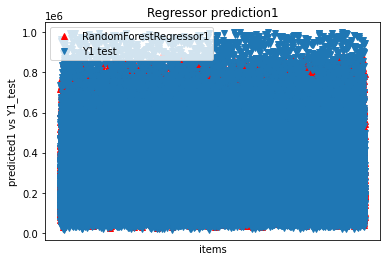

In [87]:
plt.figure()
plt.plot(prediction1, 'r^', label='RandomForestRegressor1')
plt.plot(Y1_test, 'v', label='Y1 test')
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test')
plt.xlabel('items')
plt.legend(loc="best")
plt.title('Regressor prediction1')

plt.show()

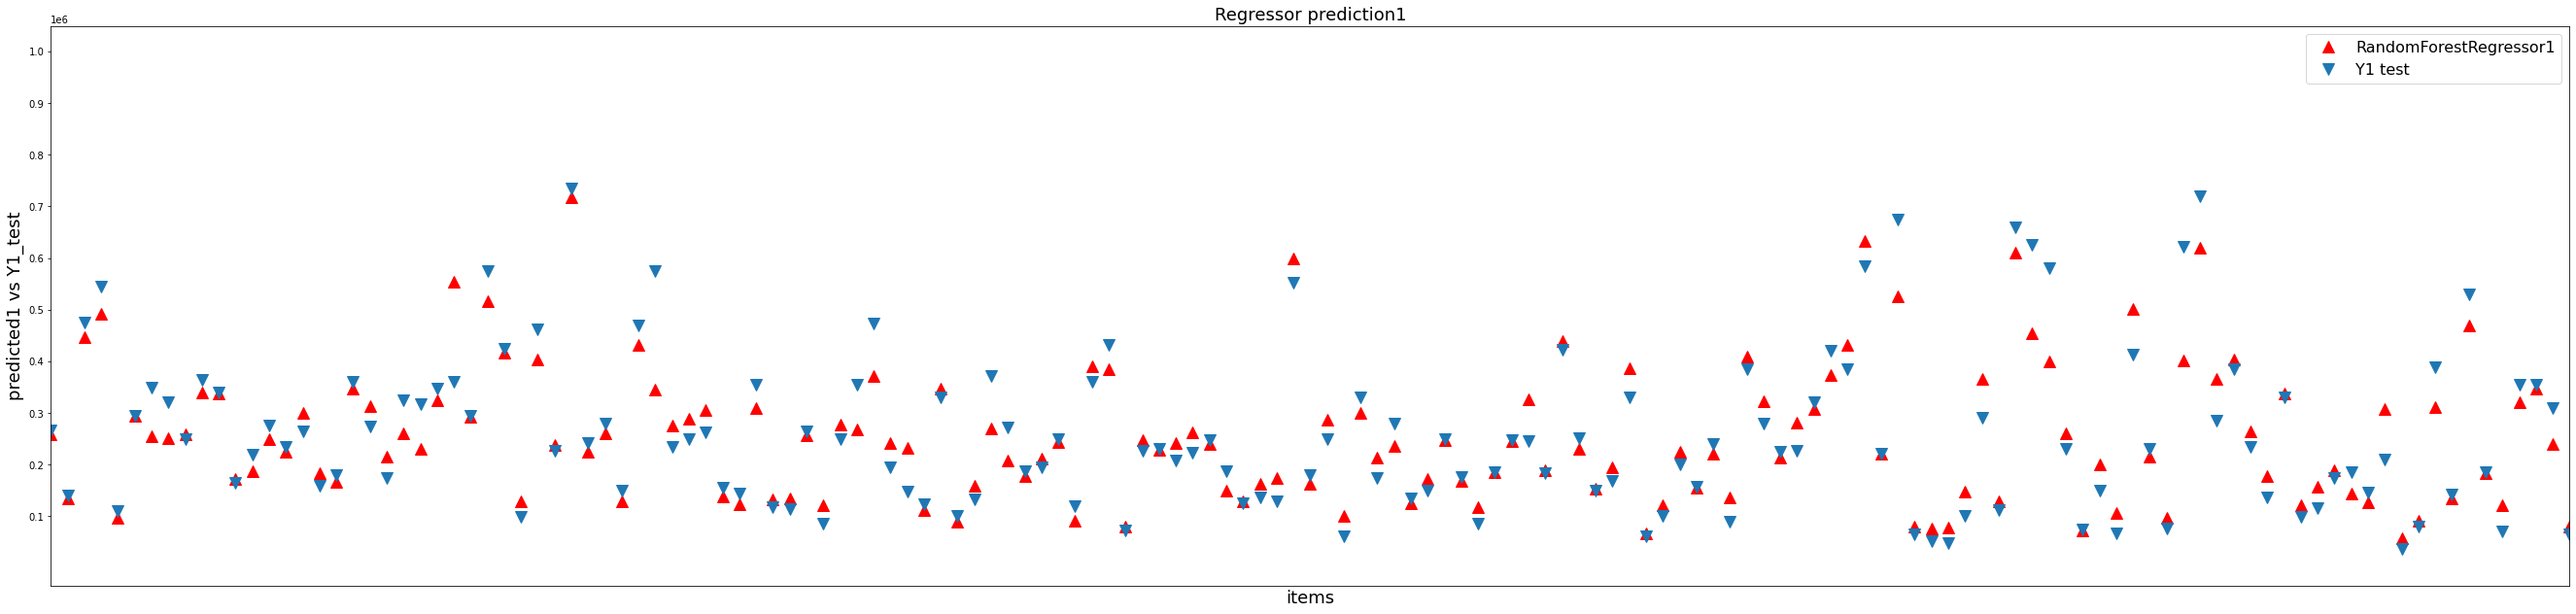

In [88]:
a= plt.figure()
axes= a.add_axes([0,0,6,2])#sequence of [left, bottom, width, height] quantities.
#axes= a.add_axes([0.2,0.2,8,8])
# adding axes
#x= np.arange(0,11)
#axes.plot(prediction, marker='*')
y = np.array([100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1100000,1200000, 1300000,1400000])
plt.yticks(np.arange(y.min(), y.max(), 100000))

axes.plot(prediction1, 'r^', label='RandomForestRegressor1',markersize=12)
axes.plot(Y1_test, 'v', label='Y1 test',markersize=12)
axes.set_xlim([0,150])
plt.tick_params(axis='x', which='both', bottom=False, top=False,
                labelbottom=False)
plt.ylabel('predicted1 vs Y1_test', fontsize=18)
plt.xlabel('items', fontsize=18)
plt.legend(loc="best",prop={'size': 16})
plt.title('Regressor prediction1', fontsize=18)

plt.show()

In [89]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error

In [90]:
mean_squared_error1=metrics.mean_squared_error(prediction1,Y1_test)
mean_squared_error1
root_mse1_2=pow(mean_squared_error1,0.5)
root_mse1_2

61317.8462778589

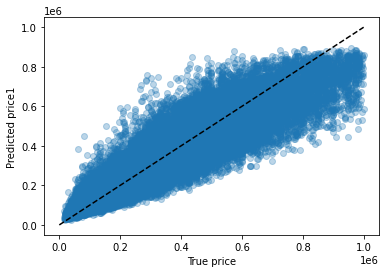

In [91]:
plt.scatter(Y1_test,prediction1,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price1')
plt.show()


In [92]:
mean_squared_error_validation=metrics.mean_squared_error(prediction_validation,Y_Validation)
mean_squared_error_validation
root_msev_2=pow(mean_squared_error_validation,0.5)
root_msev_2

62339.71673598159

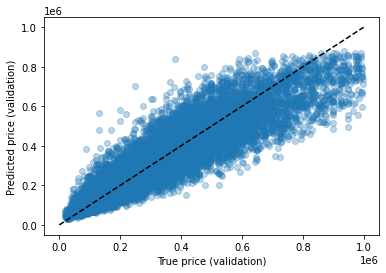

In [93]:
plt.scatter(Y_Validation,prediction_validation,alpha=0.3)
plt.plot([0,1000000],[0,1000000],'--k')
plt.axis('tight')
plt.xlabel('True price (validation)')
plt.ylabel('Predicted price (validation)')
plt.show()